### Demonstration of parameterisation of structure and history matching

This code uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_22332\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2500, 2500)] #[(2000, 2000), (4000,4000)]
P.xypumpbores = [] #[(2000, 2000), (4000,4000)]
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500), (1500, 3500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 30  # 8/5 was 50 - number of layers for voxel transect grid

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

P.geo_bores = ['P1', 'P2', 'P3', 'P4']
P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

P.nts_past = 12
P.tdis_past = [(365, P.nts_past, 1.0)] # period length, number of timesteps, tsmult
P.qwell_past = -100000 #m3/d 

P.nts_future = 5 * 6
P.tdis_future = [(5 * 365, P.nts_future, 1.0)] # period length, number of timesteps, tsmult
P.qwell_future = -200000 #m3/d 

P.zobs = [-40, -50, -100, -200, -300]

P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_top, wel_bot = -50, -100
    P.wel_screens.append((wel_top, wel_bot))
    
vtk_workspace = 'vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

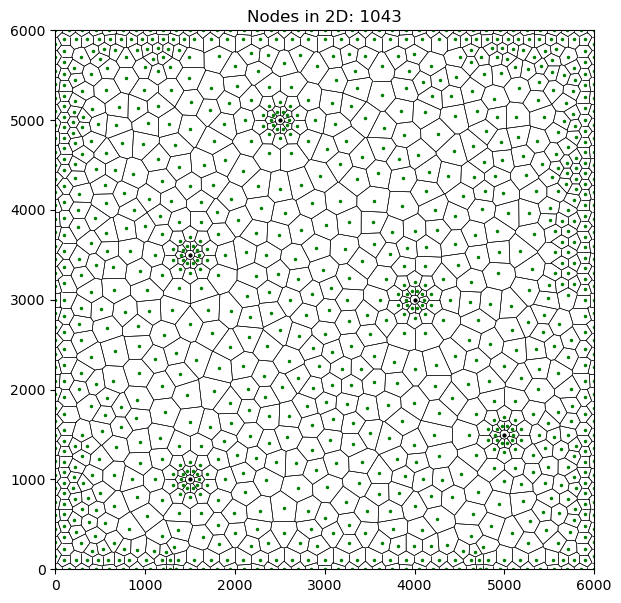

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

### 3. Geological model

In [4]:
#----------- GEO MODEL PARAMETERS-------------------
#P.control_points = (['CP1', 'control', 3000, 3000, -150, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.control_points = ([])

# ----------- PREPARE GOEMODEL----------------------------
bore_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "inverse_example")
P.data, P.strat = prepare_geomodel_loopshowcase(P, bore_data, include_fault = False)     # Prepare geomodel inputs
#print(P.strat)
#P.data

In [5]:
# -------------- CREATE GEOMODEL-------------------
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


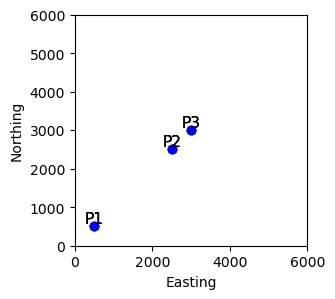

In [6]:
#P.geomodel.feature_names()
plot_bores(P)

In [7]:
# Plot geo model
upper_levels, lower_levels = [-99999, -50, 0, 99999], [-99999, -200, -100, -50, 99999]
#plot_geo_2D(P.geomodel, 1000, upper_levels, lower_levels)
#plot_geo_2D(P.geomodel, 3000, upper_levels, lower_levels)
#plot_geo_2D(P.geomodel, 4000, upper_levels, lower_levels)
#plot_geo_2D(P.geomodel, 5000, upper_levels, lower_levels)

### 4. Flow model

In [8]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

# Initiate models
M = Model('loopshowcase', P, plan = 'vor', transect = 'con') 
M.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
M.create_prop_arrays(P)         # Create property arrays (NPF)
M.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)

print(M.modelname, ' has ', M.nnodes_div, ' nodes.')

Creating lithology and discretisation arrays for  loopshowcase  ...
Time taken =  1.529138
Creating property arrays for  loopshowcase  ...
Time taken =  0.010151
Adding flow packages to  loopshowcase  ...
Time taken =  0.769744
loopshowcase  has  12516  nodes.


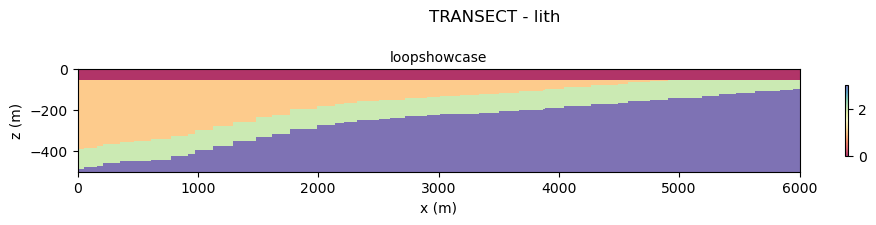

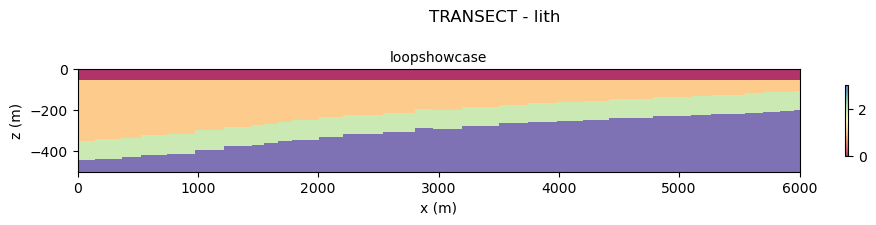

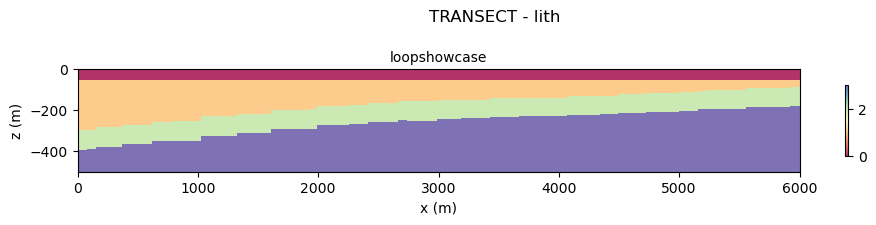

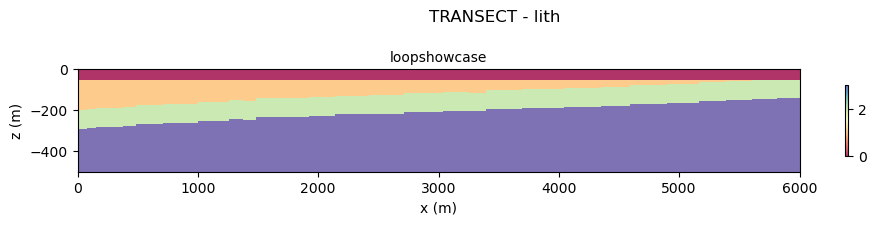

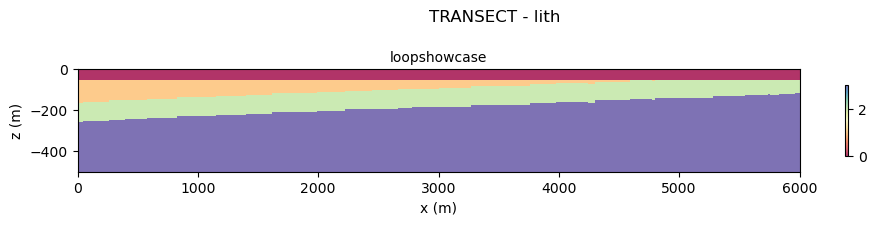

In [9]:
multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 
multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 1000, X1 = P.x1, Y1 = 1000)
multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 2000, X1 = P.x1, Y1 = 2000)
multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 4000, X1 = P.x1, Y1 = 4000)
multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 5000, X1 = P.x1, Y1 = 5000)

In [10]:
M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   

Writing simulation and gwf for  loopshowcase  ...
loopshowcase
Running simulation for  loopshowcase  ...
Period =  Steady 
Model success =  True
run_time =  16.057107


In [11]:
f = os.path.join(vtk_workspace, "test", M.modelname)
M.gwf.export(f, fmt="vtk")

'vtk_files\\test\\loopshowcase'

### 5. Plot Results

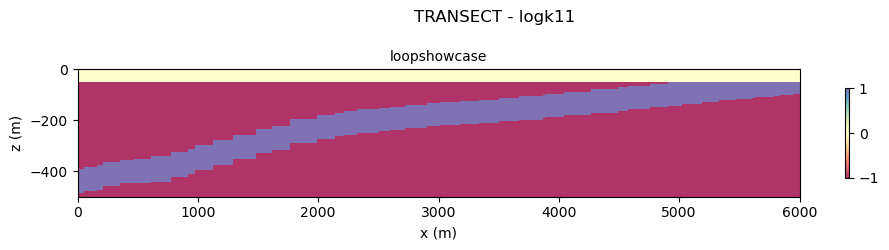

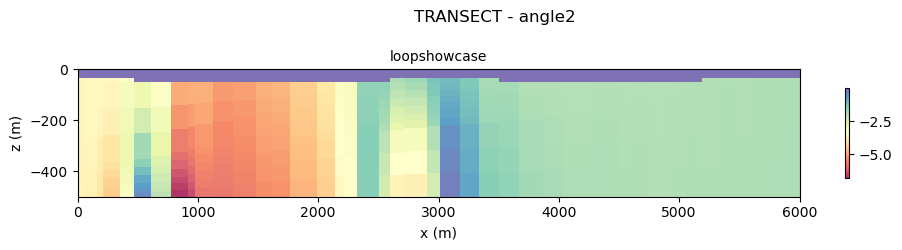

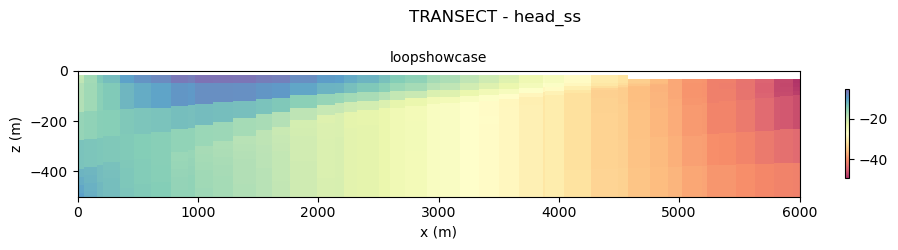

C:\Users\19904604\AppData\Local\Temp\ipykernel_22332\2177837678.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


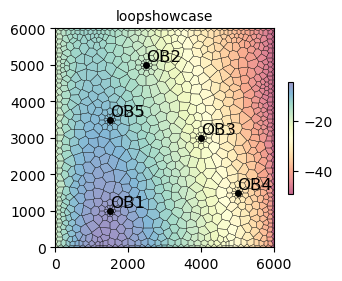

In [12]:
#plot_flow_features(P, [M])
multiplot_prop_transect(P, models = [M], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = [M], array = 'angle2', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = [M], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = vmin, vmax = vmax)
plot_bylayer(P, models = [M], layer = 2)#, vmin = -20, vmax = 5) 

## Multiple Simulations

### Pinchouts

In [13]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20
P.xyobsbores = [(1500,1000), (2500, 5000), (2500, 2500), (5000,5000)] 
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("loop_showcase_data.xls",sheet_name = "pinchout_example")

options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data = data, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    pinchout_obs_heads.append((process_obs(P, M)))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")

IndexError: list index out of range

In [ ]:
"""# Run reference
P.ncol = 50  
P.nrow = 50  
P.nlv  = 50  
P.delx = P.Lx/P.ncol
P.dely = P.Ly/P.nrow
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False) 
R = Model('ref', P, plan = 'car', transect = 'vox') 
P.control_points = (['CP1', 'control', 3000, 3000, -180, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, include_fault = False)  
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) 
R.create_lith_dis_arrays(P)                             
R.create_prop_arrays(P)                                   
R.create_flow_package_arrays(P)                             
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady')   
pinchout_ref_heads = (process_obs(P, R))
# Plot Reference
plot_bylayer(P, models = [R], layer = 2, vmin = -25, vmax = 70) 
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)"""

In [ ]:
M = pinchout_models[0]
M.k11

In [ ]:
%run ./loop_showcase_functions.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb
# Plot multiple sims
plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
plot_bylayer(P, models = pinchout_models, layer = 2, vmin = -40, vmax = 20) 
multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [ ]:
plot_bores(P)

### Faults

In [ ]:
P.xyobsbores = [(1500,1000), (2000, 2300), (4000, 3000), (5000,1500)] 
del P.cell2dvor
del P.xcycvor
del P.verticesvor
del P.vor
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)   
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

In [ ]:
%run ./loop_showcase_functions.ipynb
options = np.linspace(0, 320, 6) # Fault displacement

P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20
bore_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "fault_example")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] /2
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data = bore_data, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    fault_obs_heads.append((process_obs(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

In [ ]:
plot_bores(P)

In [ ]:
options = np.linspace(0, 320, 6)

In [ ]:
# PLOTS
%run ./loop_showcase_functions.ipynb
plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [ ]:
multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [ ]:
plot_bores(P)

### Bedding Angle

In [ ]:
%run ./loop_showcase_functions.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb

options = [False, True]
P.hk = [5, 100, 1, 1] 
P.vk = [5, 0.1, 0.1, 1]

P.ncol = 60  
P.nrow = 60  
P.nlv  = 50  
P.delx = P.Lx/P.ncol
P.dely = P.Ly/P.nrow

P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False) 
P.control_points = ([]) 
bore_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "bedding_example")
P.data, P.strat = prepare_geomodel_loopshowcase(P, bore_data, include_fault = False) 
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) 

plot_bores(P)
#upper_levels, lower_levels = [-99999, -50, 0, 99999], [-99999, -200, -100, -50, 99999]
#plot_geo_2D_WE(P.geomodel, 1000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 2000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 3000, upper_levels, lower_levels)
#plot_geo_2D_WE(P.geomodel, 4000, upper_levels, lower_levels)

In [ ]:
bedding_modelnames = []    
bedding_models = []
bedding_obs_heads = []

for i in range(len(options)):
    bedding_modelnames.append(str('BA_'+str(options[i])))
    bedding_models.append(Model(bedding_modelnames[i], P, plan = 'car', transect = 'vox'))
    P.xt3d = options[i]
    M = bedding_models[i]
    M.create_lith_dis_arrays(P)                                
    M.create_prop_arrays(P)                                     
    M.create_flow_package_arrays(P)                            
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    bedding_obs_heads.append((process_obs(P, M)))

In [ ]:
multiplot_prop_transect(P, models = bedding_models, array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = bedding_models, array = 'angle2', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = bedding_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = vmin, vmax = vmax)

In [ ]:
levels = np.arange(-40, 0, 2)      
levels

In [ ]:
def plot(P, models, array, X0, Y0, X1, Y1, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    nmodels = len(models)
    if nmodels > 1: fig = plt.figure(figsize = (10,2*nmodels))
    if nmodels ==1: fig = plt.figure(figsize = (10,2.5))
    fig.suptitle("TRANSECT - " + array)
    for i in range(nmodels):
        M = models[i]
        model = M.gwf
        a = getattr(M, array)
        
        ax = plt.subplot(nmodels, 1, i+1)
        ax.set_title(M.modelname, size = 10) 
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
        CS = xsect.contour_array(a = a, colors='Blue', levels = levels)#[-45,-40,-35,-30,-25,-20,-15,-10,-5])
        ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')
        #CS = ax.contour(xc, zc, a, levels,colors='Blue', linestyles = 'solid', linewidths=1.0)
        if i == nmodels-1: ax.set_xlabel('x (m)', size = 10)
        if i == int(nmodels/2): ax.set_ylabel('z (m)', size = 10)
        if nmodels>1: linecollection = xsect.plot_grid(lw = 0.1, color = 'black') # Don't plot grid for reference
        plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()    

plot(P, models = bedding_models, array = 'head_ss', X0 = 0, Y0 = 4000, X1 = P.x1, Y1 = 4000)# vmin = 20, vmax = 65)#


In [ ]:
# PLOTS
%run ./loop_showcase_functions.ipynb
plot_observations(heads = bedding_obs_heads, modelnames = bedding_modelnames, ylim = [-40, -10])
plot_bylayer(P, models = bedding_models, layer = 4, vmin = -40, vmax = -10) 
multiplot_vgrid_transect(P, models = bedding_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

#### Angle example

In [ ]:
%run ./loop_showcase_functions.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb

P.hk = [1, 1, 1, 1] 
P.vk = [1, 1, 1, 1]

P.ncol = 60  
P.nrow = 60  
P.nlv  = 50  
P.delx = P.Lx/P.ncol
P.dely = P.Ly/P.nrow

P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False) 
P.control_points = ([]) 
bore_data = pd.read_excel("loop_showcase_data.xls",sheet_name = "angle_example")
P.data, P.strat = prepare_geomodel_loopshowcase(P, bore_data, include_fault = False) 
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) 

M = Model('angle_example', P, plan = 'car', transect = 'vox')
M.create_lith_dis_arrays(P)                                
M.create_prop_arrays(P)                                     
M.create_flow_package_arrays(P)                            
M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   

    


In [ ]:
multiplot_prop_transect(P, models = [M], array = 'logk11', X0 = P.x0, Y0 = 3000, X1 = P.x1, Y1 = 3000,)
multiplot_prop_transect(P, models = [M], array = 'angle2', X0 = P.x0, Y0 = 3000, X1 = P.x1, Y1 = 3000,)

In [ ]:
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb
multiplot_prop_plan(P, models = [M], array = 'angle1', layer = 25, vmin = None, vmax = None)

In [ ]:
f = os.path.join(vtk_workspace, "angle", M.modelname)
M.gwf.export(f, fmt="vtk")

### 10. Run Past 

In [ ]:
if run_past:  
    M.gwf, M.head_present, M.obs_present, M.runtime_present = M.write_run_model(P, period = 'Past') 
    

In [ ]:
multiplot_prop_transect(P, models = [M], array = 'head_present', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
                    #vmin = -20, vmax = 5)

### 13. Plot observations for multiple models

In [ ]:
models = [CV, TV, VV, CC, TC, VC, R]

# Reorganise observation data to make easier to work with my adding as variable to Model Class
# Obs data is by location then depth

# ------------------  STEADY ------------------
for i, M in enumerate(models):
    M.hobs_steady = np.zeros((P.nobs, len(P.zobs), 1), dtype = float)
    fname = str(M.modelname + "_steady.csv")
    csv_file = os.path.join(P.workspace, fname)
    data_set = pd.read_csv(csv_file)#, header=1)
    df = pd.DataFrame(data_set)
    a = df.to_numpy()
    hobs = a[0][1:(P.nobs*len(P.zobs)+1)]
    for ob_bore in range(P.nobs):
        for z in range(len(P.zobs)):
            n = ob_bore*len(P.zobs) + z
            M.hobs_steady[ob_bore, z] = hobs[n]
            
# ------------------  PAST ------------------
for i, M in enumerate(models):
    M.hobs_past = np.zeros((P.nobs, len(P.zobs), P.nts_past-1), dtype = float)
    fname = str(M.modelname + "_past.csv")
    csv_file = os.path.join(P.workspace, fname)
    data_set = pd.read_csv(csv_file, header=1)
    data_frames = pd.DataFrame(data_set)
    hobs = np.array(data_frames.values)
    hobs = hobs[:,1:]
    hobs = np.swapaxes(hobs, 0, 1)
    for ob_bore in range(P.nobs):
        for z in range(len(P.zobs)):
            n = ob_bore*len(P.zobs) + z
            M.hobs_past[ob_bore, z, :] = hobs[n,:]
            
# ------------------  FUTURE------------------
'''for i, M in enumerate(models):
    M.hobs_future = np.zeros((P.nobs, len(P.zobs), P.nts_future-1), dtype = float)
    fname = str(M.modelname + "_future.csv")
    csv_file = os.path.join(P.workspace, fname)
    data_set = pd.read_csv(csv_file, header=1)
    data_frames = pd.DataFrame(data_set)
    hobs = np.array(data_frames.values)
    hobs = hobs[:,1:]
    hobs = np.swapaxes(hobs, 0, 1)
    for ob_bore in range(P.nobs):
        for z in range(len(P.zobs)):
            n = ob_bore*len(P.zobs) + z
            M.hobs_future[ob_bore, z, :] = hobs[n,:]'''


In [ ]:
#------------- PAST --------------------------
models = [CV, TV, VV, CC, TC, VC, R]
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    fig = plt.figure(figsize = (8,4))
    fig.suptitle(P.idobsbores[ob])
    
    for d, depth in enumerate(P.zobs): # 6 panels for each depth
        ax = plt.subplot(2,3,d+1)
        ax.set_title(str(str(depth) + ' m'), size = 10) 

        for i, M in enumerate(models): # colored line for each model
            ax.plot(np.array(M.hobs_past[ob,d]), ls = line_styles[i], color = colors[i])
        if d == 0 or d ==3: ax.set_ylabel('Head (m)')
        if d < 3: ax.set_xticks([])
        #ax.set_ylim([0,80])    
        
    ax.legend(modelnames, loc = 'lower right')

### 14. Create "truth" observations and plot observations

In [ ]:
# RETRIEVE OBS HEADS FOR PAST
data_set = pd.read_csv('../modelfiles/Ref_past.csv', header=1)
data_frames = pd.DataFrame(data_set)
ref_obs = np.array(data_frames.values)
ref_obs = ref_obs[:,1::] # Cut off time column
ref_obs = np.swapaxes(ref_obs, 0, 1) # Make first axis as obs point, second axis as time
nobs, nts = ref_obs.shape[0], ref_obs.shape[1]

# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.1#0.2
hobs_perturbed = np.copy(ref_obs)    
for i in range(nobs):
    for j in range(nts): 
        hobs_perturbed[i][j] += np.random.normal(0.,err) # Perturb samples either side of measurement
hobs_ref_past = [] # Sample every few time steps 
for i in range(nobs):
    hobs_ref_past.append(hobs_perturbed[i][::2]) # Sample every 2 time steps
ns = len(hobs_ref_past[0]) # number of samples in time
print(ns)

In [ ]:
for i in range(P.nobs):
    plt.title('Observation data from the "TRUE" scenario')
    plt.plot(hobs_ref_past[i],'-o', ms = 5)
    plt.legend(np.linspace(0,nobs-1, nobs))

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [ ]:
def Likelihood(obs,mod,err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

from DREAM import *

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(P.hk[i]))
    Width.append(0.33) # SIGMA
    Min.append(np.log10(P.hk[i])-1) 
    Max.append(np.log10(P.hk[i])+1) 
    
for i in range(len(P.vk)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(P.vk[i]))
    Width.append(0.33)
    Min.append(np.log10(P.vk[i])-1) 
    Max.append(np.log10(P.vk[i])+1)
    
for i in range(len(P.ss)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(P.ss[i]))
    Width.append(0.33)
    Min.append(np.log10(P.ss[i])-1)
    Max.append(np.log10(P.ss[i])+1)

In [ ]:
print(np.log10(P.hk), np.log10(P.vk), np.log10(P.ss))

#### Set up DREAM and define "run model" function

In [ ]:
## DREAM for Steady State
err = 0.1
nchains = 5     #number of parrallel chains 
npars = len(Mean)  #number of parameters
nburn = 20
nsamples = 100

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

#### Run first sample to get first likelihood

In [ ]:
M = CC
#run_time_results = np.zeros((len(models), 3, nruns)) 

In [ ]:
if run_MCMC: 
    
    #h_mod_current = [] # list with 1 entry for each chain, that contains the last accepted parameters head result
    #h_pred_current = [] # list with 1 entry for each hhaon that saves the predicted heads.    
    
    for i in range(nchains):
        print('------------------------------------------------------')
        print("Chain = ", i)
        #hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss0, ss1, ss2, ss3
        np.set_printoptions(precision=3)
        
        print(D.chains[i].current[0],
                             D.chains[i].current[1],
                             D.chains[i].current[2],
                             D.chains[i].current[3],
                             D.chains[i].current[4],
                             D.chains[i].current[5],
                             D.chains[i].current[6],
                             D.chains[i].current[7],
                             D.chains[i].current[8],
                             D.chains[i].current[9],
                             D.chains[i].current[10],
                             D.chains[i].current[11],)
        
        hmod, run_time = model_make_n_run(D.chains[i].current[0],
                             D.chains[i].current[1],
                             D.chains[i].current[2],
                             D.chains[i].current[3],
                             D.chains[i].current[4],
                             D.chains[i].current[5],
                             D.chains[i].current[6],
                             D.chains[i].current[7],
                             D.chains[i].current[8],
                             D.chains[i].current[9],
                             D.chains[i].current[10],
                             D.chains[i].current[11],) 

        print('RUN TIME ', run_time)
        hmod = hmod[:,::4] # Resample observation data
        a = np.array(hobs_ref_past).flatten()
        b = np.array(hmod).flatten()
        print(a.shape, b.shape)
        D.chains[i].Lold = Likelihood(np.array(hobs_ref_past).flatten(), np.array(hmod).flatten(), err)

        plt.plot(np.array(hobs_ref_past).flatten(), 'o')
        plt.plot(np.array(hmod).flatten())
        plt.ylabel('Head (m)')
        plt.xlabel('')
        plt.legend()

#### Run all samples (LONG TIME TO RUN!)

In [ ]:
if run_MCMC: 
    fname = os.path.join(workspace, modelname + '_pars.dat')
    f = open(fname,'w')  #saves the pars  
    f.close()

    hobs_past_all, hobs_pred = [], [] # to save prediction results
    runtime_past_all = []
    for i in range(nsamples):
        for j in range(nchains):
            print("----------Sample = %i, Chain = %i----------" %(i, j))
            prop = D.propgenzs(D.chains[j].current,lookback = 10)
            Lnewdum = np.zeros(D.k)
            for k in range(D.k):
                print('range of m = ', D.k)
                print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
                hmod, run_time = model_make_n_run(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
                hmod = hmod[:,::4]
                a = np.array(hobs_ref_past).flatten()
                b = hmod.flatten()
                print(a.shape, b.shape)
                Lnewdum[k] = Likelihood(np.array(hobs_ref_past).flatten(), hmod.flatten(), err)
                #print(Lnewdum[k])
                #hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss0, ss1, ss2, ss3
                print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
            L2dum = np.zeros_like(Lnewdum)
            kk = np.argmax(Lnewdum)
            prop2 = D.propgenzs(prop[kk,:],lookback = 10)
            prop2[-1,:] = D.chains[j].current
            L2dum[-1] = D.chains[j].Lold
            for m in range(D.k-1): 
                
                hmod, run_time = model_make_n_run(prop[m,0],  prop[m,1],  prop[m,2],  prop[m,3],  prop[m,4],  prop[m,5],
                                     prop[m,6],  prop[m,7], prop[m,8], prop[m,9], prop[m,10], prop[m,11])                                

                hmod = hmod[:,::4]

                L2dum[m] = Likelihood(np.array(hobs_ref_past).flatten(), hmod.flatten(), err)
                   
            tp = np.sum(Lnewdum)-np.sum(L2dum) # Transition Probability
            print('Last likelihood ' + str(D.chains[j].Lold) + 'Proposed likelihood', str(Lnewdum[kk]))
            if np.random.rand() < np.exp(tp): # If we accept parameters...

                D.chains[j].Lold = Lnewdum[kk]
                D.chains[j].current = prop[kk,:] 
                if i > nburn:                                      # If its past our burn period, we run a prediction...
                    print('\nAccepted! Saving parameters and runnning prediction...')
                    hobs_past_all.append(hmod)           # We wants to save head and look at later....
                    runtime_past_all.append(run_time)    # We wants to save the runtime
                    hpred = run_prediction(M, prop[kk,:])           # RUN PREDICTION
                    hobs_pred.append(hpred)                         # Save the prediction
            D.chains[j].pars = np.vstack((D.chains[j].pars,D.chains[j].current))
            D.chains[j].likelihood = np.append(D.chains[j].likelihood,D.chains[j].Lold)
        
        D.gen_mod()
        #print(D.rate)
        fname = os.path.join(workspace, modelname + '_pars.dat')
        f = open(fname,'a')
        for i in range(nchains):
            f.write('%g ' % D.chains[i].Lold)
            for j in range(npars):
                f.write('%g ' %  D.chains[i].current[j])
            f.write('\n')
        f.close()
        
    for i in range(nchains): # For each chain
        plt.plot(D.chains[i].likelihood)#, 'o', ms = 2)

    plt.ylabel('ln(Likelihood)')
    plt.xlabel('Samples')

    plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
    plt.axvline(nburn)
    plt.text(nburn - 40,-200,'Burn in') 
    plt.text(nburn + 5,-200,'Sampling')
      
    fname = '../results/' + modelname + '_hobs_past.pkl'
    pickle.dump(hobs_past_all, open(os.path.join(workspace, fname),'wb'))
    
    fname = '../results/' +  modelname + '_hobs_pred.pkl' # Pickle the future
    pickle.dump(hobs_pred, open(os.path.join(workspace, fname),'wb'))

#### Plot parameter estimates

In [ ]:
fname = os.path.join(workspace, modelname + '_pars.dat')
B = np.loadtxt(fname)[nburn*nchains:,1:]
print(B.shape) #750, 12
A = B.reshape((nsamples-nburn, nchains, npars))


In [ ]:
colors = ['b','c','r','g', 'y']
for i in range(npars):
    plt.plot(B[:,i], 'o',ms=1)
plt.legend(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3', 'ss0', 'ss1', 'ss2', 'ss3'])
plt.xlabel('samples x chains')
plt.ylabel('value (log K)')

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))
    
fig, ax = plt.subplots(1,1, figsize = (6,4))
for i in range(nsamples*nchains - nburn*nchains): 
    for j in range(npars):
        ax.plot(j, B[i,j],'o', ms = 2.)

for j in range(npars):
    ax.plot(j,Mean[j], 'o', ms = 5., color = 'black')
ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,12,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3', 'ss0', 'ss1', 'ss2', 'ss3'])
ax.set_ylabel('Log Value')

### Compare predicted vs truth (PAST)

In [ ]:
# Load REALITY past
fname = "REF_past.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
times_past = times_past[::4] # resample every 4

reality_past = np.array(df.values) # turn df to array
reality_past = reality_past[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_past = reality_past[::4] # sample period every 4
reality_past = np.swapaxes(reality_past, 0, 1) # better to have obs as axis 0
print('reality past shape ', reality_past.shape) # 9 obs, 6 times

# Load REALITY past
fname = "REF_future.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365
times_future = times_future[::4] # resample every 4

reality_future = np.array(df.values) # turn df to array
reality_future = reality_future[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_future = reality_future[::4] # sample period every 4
reality_future = np.swapaxes(reality_future, 0, 1) # better to have obs as axis 0
print('reality future shape ', reality_future.shape) # 9 obs, 6 times

In [ ]:
# Load PAST HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_past.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)
print('obs_past shape ', obs_past.shape) #(445, 9, 6)

# Load PREDICTED HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_pred.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)
obs_future = obs_future[:,:,::4]
print('obs_future shape', obs_future.shape) #(290, 9, 29)

### Plot reality vs past and predicted

In [ ]:
len(obs_past)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3),3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    # PLOT PAST
    for i in range(len(obs_past)):
        ax.plot(times_past, obs_past[i][n], 'o', ms = 2 ) 
    ax.plot(times_past, reality_past[n], lw = 2, color = 'black') # Plot truth
    
    # PLOT FUTURE
    for i in range(len(obs_future)):
        ax.plot(times_future + 2, obs_future[i][n], 'o', ms = 2 ) 
    ax.plot(times_future + 2, reality_future[n], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): 
        ax.set_xlabel('Time (years)', size = 10)
        ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2)
    #ax.set_ylim([0,80])
    

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3), 3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    ax.hist(obs_future[:,n,-1], bins = 15)
    ax.axvline(reality_future[n, -1], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): ax.set_xlabel('Predicted head (m)', size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Frequency', size = 10)
    ax.set_xlim([reality_future[n, -1] - 10, reality_future[n, -1] + 10])
    #ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
help(flopy.discretization.VertexGrid)
Car = flopy.discretization.VertexGrid(vertices = self.vertices, cell2d = self.cell2d, top = self.top)

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""